Lets keep the architecture same as Architecture 2 , there we got 65% accuracy on test and 75% accuracy on train set

Goals :: Introduce Weight Decay and study the accuracy for different values sampled over a log scale
### Regularization with 1e-5 didnt help much

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 6 Layers : 3 conv layers and 3 fully connected layers !
        self.conv1 = nn.Conv2d(3, 8, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5,padding=2)
        self.conv3 = nn.Conv2d(16, 32, 5,padding=2)
        self.fc1 = nn.Linear(32*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 *4* 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Create an instance of the model on CUDA
net = Net().cuda()

# net=Net()

lossvsiter=[]

# To see if the model is on CUDA or not !
if (next(net.parameters()).is_cuda) :
    print("The model is on CUDA")
else :
    print("The model is on CPU")

# Import the optimizers 
import torch.optim as optim

# Declare a loss function
criterion = nn.CrossEntropyLoss()

# Declare an optimizer
optimizer = optim.Adam(net.parameters(),weight_decay=1e-5)

#No of iterations !
iterations = 15


for epoch in range(iterations):  # loop over the dataset multiple times
    
    # Reset the loss for the current epoch !
    running_loss = 0.0
    
    # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable & if possible make them cuda tensors
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients for the current epoch
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Calculate gradients of whatever variable set to req_gardients = True
        loss.backward()
        
        # Take one step of the gradient descent for this epoch ! 
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            lossvsiter.append(running_loss / 2000)
            running_loss = 0.0
        

print('Finished Training')

The model is on CUDA
[Epoch :: 1, Mini Batch ::  2000] loss: 1.912
[Epoch :: 1, Mini Batch ::  4000] loss: 1.613
[Epoch :: 1, Mini Batch ::  6000] loss: 1.473
[Epoch :: 1, Mini Batch ::  8000] loss: 1.416
[Epoch :: 1, Mini Batch :: 10000] loss: 1.375
[Epoch :: 1, Mini Batch :: 12000] loss: 1.336
[Epoch :: 2, Mini Batch ::  2000] loss: 1.229
[Epoch :: 2, Mini Batch ::  4000] loss: 1.206
[Epoch :: 2, Mini Batch ::  6000] loss: 1.206
[Epoch :: 2, Mini Batch ::  8000] loss: 1.199
[Epoch :: 2, Mini Batch :: 10000] loss: 1.162
[Epoch :: 2, Mini Batch :: 12000] loss: 1.165
[Epoch :: 3, Mini Batch ::  2000] loss: 1.108
[Epoch :: 3, Mini Batch ::  4000] loss: 1.072
[Epoch :: 3, Mini Batch ::  6000] loss: 1.091
[Epoch :: 3, Mini Batch ::  8000] loss: 1.068
[Epoch :: 3, Mini Batch :: 10000] loss: 1.077
[Epoch :: 3, Mini Batch :: 12000] loss: 1.080
[Epoch :: 4, Mini Batch ::  2000] loss: 0.992
[Epoch :: 4, Mini Batch ::  4000] loss: 0.999
[Epoch :: 4, Mini Batch ::  6000] loss: 1.006
[Epoch :: 4, 

In [6]:
import pickle

In [7]:
with open("PyTorch-Architecture-2-with-reg.pkl","wb") as f:
    pickle.dump(lossvsiter,f)

In [8]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    try:
        outputs = net(Variable(images))
    except RuntimeError as re:
        print(outputs.is_cuda)
        print(str(re))
        sys.exit()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [9]:
for i, data in enumerate(trainloader, 0):
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    try:
        outputs = net(Variable(images))
    except RuntimeError as re:
        print(outputs.is_cuda)
        print(str(re))
        sys.exit()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    if (i%1000) == 0:
        print(i)

print('Accuracy of the network on the 50000 trained images: %d %%' % (
    100 * correct / total))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
Accuracy of the network on the 50000 trained images: 74 %


In [10]:
correct

44431

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 76 %
Accuracy of   car : 88 %
Accuracy of  bird : 57 %
Accuracy of   cat : 46 %
Accuracy of  deer : 57 %
Accuracy of   dog : 46 %
Accuracy of  frog : 64 %
Accuracy of horse : 70 %
Accuracy of  ship : 76 %
Accuracy of truck : 60 %


In [12]:
lossvsiter

[1.9121172297298907,
 1.6129605130255222,
 1.4729537923783065,
 1.416227998584509,
 1.375367299631238,
 1.3362291313260795,
 1.2292245556712151,
 1.2056728691607714,
 1.2056791387498378,
 1.1985564230382442,
 1.16192292791605,
 1.164634777367115,
 1.107630993247032,
 1.0718171118497848,
 1.0913361265659332,
 1.0682286374121905,
 1.0765112414211035,
 1.0802829616889358,
 0.9918590277731418,
 0.9985699627324939,
 1.0057257095724343,
 1.0352969634756446,
 1.0412683415338397,
 1.0340903357714415,
 0.9326629136800766,
 0.9448711917363107,
 0.9578155973255634,
 0.9737446712702513,
 0.995305515371263,
 0.9731355479322373,
 0.8667125270105899,
 0.9121933790966869,
 0.9335940982848406,
 0.9277727754376829,
 0.9338530479259789,
 0.9420998954158276,
 0.8389087582714856,
 0.8672108516469598,
 0.8884238287657499,
 0.9122314798012375,
 0.8810214663296938,
 0.9146589816119521,
 0.8068617780730128,
 0.8266580955078825,
 0.8390151681266725,
 0.8527508663097396,
 0.8825953815784305,
 0.8799839144395665,

In [13]:
%matplotlib inline

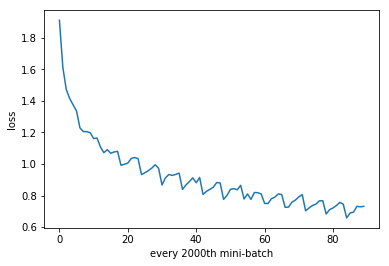

In [14]:
import matplotlib.pyplot as plt
plt.plot(lossvsiter)
plt.ylabel('loss')
plt.xlabel('every 2000th mini-batch')
plt.show()

In [15]:
# Lets save the model !!

In [17]:
 torch.save(net.state_dict(),"./models/archi2-with-reg-e5")